## What do people talk about with whom?

In this notebook we will further analyse the relationships between users in the network and the topics they talk about.

More specifically, questions that we want to answer are:
- Which users talk about which topic?
- Which connections talk a lot about a particular topic?

In order to do this we will first add a topic to each conversation and add each topic to each user and connection.

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# load dataset as pandas dataframe
df = pd.read_csv('Twitter_ISIS_data/how-isis-uses-twitter/tweets.csv')

In [3]:
# create list of stopwords for topic analysis
from nltk.corpus import stopwords

english_stopwords = list(set(stopwords.words('english')))
french_stopwords = list(set(stopwords.words('french')))
turkish_stopwords = list(set(stopwords.words('turkish')))

stopwords = english_stopwords + french_stopwords + turkish_stopwords

In [4]:
def get_topic_relevancy_per_message(list_of_document_index_and_message, no_features=1000, no_topics=4, stop_words=stopwords): # include parameters in function (no_features, no_topics)

    document_index = [row[0] for row in list_of_document_index_and_message]
    documents = [row[1] for row in list_of_document_index_and_message]

    # get term counts 
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=stopwords)
    tf = tf_vectorizer.fit_transform(documents)
    tf_feature_names = tf_vectorizer.get_feature_names()

    # convert to arrays
    tf_array = tf_vectorizer.fit_transform(documents).toarray()
    tf_feature_names_array = np.array(tf_vectorizer.get_feature_names())

    # run model
    lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
    doctopic = lda.fit_transform(tf_array)

    # scale the document-component matrix such that the component values associated with each document sum to one
    doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

    # give each document a name (name of the index) 
    # and convert the name of each document to an array
    documents_names = np.asarray(document_index)
    doctopic_orig = doctopic.copy()

    # create a matrix that returns the relevance of a topic per document
    num_groups = len(set(documents_names))
    doctopic_grouped = np.zeros((num_groups, no_topics))
    for i, name in enumerate(sorted(set(documents_names))):
        doctopic_grouped[i, :] = np.mean(doctopic[documents_names == name, :], axis=0)

    # get the importantance of each topic per document
    doctopic = doctopic_grouped


    # print documents
    # print display_topics(nmf, tfidf_feature_names, no_top_words) 
    # print doctopic

    return doctopic


def return_document_and_most_important_topic_and_value(list_of_document_index_and_message, no_features=1000, no_topics=4):
    
    doctopic = get_topic_relevancy_per_message(list_of_document_index_and_message, no_features=no_features, no_topics=no_topics) 

    document_index = [row[0] for row in list_of_document_index_and_message]
    documents = [row[0] for row in list_of_document_index_and_message]
    
    # give each document a name (name of the index) 
    # and convert the name of each document to an array

    doctopic_list = doctopic.tolist()
    documents_names = np.asarray(document_index)
    documents_names_list = documents_names.tolist()

    documents_names_doctopics = zip(documents_names_list, doctopic_list)
    
    # create dataframe of array with topic names as column names
    column_names = range(len(doctopic[0]))
    topic_names = ["topic" + str(i) for i in column_names]

    df = pd.DataFrame(doctopic, index=documents_names, columns=topic_names)

    # return max value for each row
    # convert column to list
    max_value = df.max(axis=1).tolist()

    # create new column that states the topic that is most important for the document 
    # convert column to list
    topic = df.idxmax(axis=1).tolist()

    # create list of most important topic and highest value per document
    document_topic_value = zip(documents_names, topic, max_value)

    return document_topic_value


def return_messages_with_clear_topic(list_of_document_index_and_message, no_features=1000, no_topics=4, threshold=0):
    """return documents where topic relevancy is > a certain level"""
    document_topic_value = return_document_and_most_important_topic_and_value(list_of_document_index_and_message, no_features=no_features, no_topics=no_topics)
    
    df = pd.DataFrame(document_topic_value, columns = ['documents_names', 'topic', 'max_value'])

    # keep only the rows where value > threshold
    df_relevant = df[df['max_value'] > threshold]

    # convert this dataframe to a list
    relevant_doctopics = df_relevant.values.tolist()

    return relevant_doctopics


def return_topwords_topdocuments_per_topic(list_of_document_index_and_message, no_topics=0, no_top_words=0, no_top_documents=0, ): 
    
    documents = [row[1] for row in list_of_document_index_and_message]
    
    # import modules
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.decomposition import LatentDirichletAllocation
    import numpy as np

    # prepare data for model
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=0.01, stop_words=stopwords)
    tf = tf_vectorizer.fit_transform(documents)
    tf_feature_names = tf_vectorizer.get_feature_names()

    lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
    lda_W = lda_model.transform(tf)
    lda_H = lda_model.components_

    def display_topwords_topdocuments_per_topic(H, W, feature_names, documents, no_top_words, no_top_documents):
        for topic_idx, topic in enumerate(H):
            print "Topic %d:" % (topic_idx)
            print " ".join([feature_names[i]
                            for i in topic.argsort()[:-no_top_words - 1:-1]])
            top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
            for doc_index in top_doc_indices:
                print documents[doc_index]
    
    return display_topwords_topdocuments_per_topic(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)

In [5]:
def topic_analysis(df):

    # remove urls from tweets
    df['tweets'] = df['tweets'].apply(lambda x: re.sub(r'http\S+', '', x))

    # create new column for tokenized tweets that returns @taggedprofile and #hashtags as one token 
    tweettknzer = TweetTokenizer()

    df['tokenized_tweets'] = df['tweets'].apply(lambda x: tweettknzer.tokenize(x))

    # create a list of tuples of tweets and index of tweet
    # add index name to dataframe
    df = df.reset_index()

    tweets = df['tweets'].tolist()
    index = df['index'].values.tolist()
    tweets_index = zip(index, tweets)

    # return list of indes, tweet topic, and topic score
    document_topic_value = return_document_and_most_important_topic_and_value(tweets_index, no_topics=4)

    # add topic to df with tweets
    row_topic = [(row[0], row[1]) for row in document_topic_value]

    # convert list of tuples to dataframe
    df_tweet_topic = pd.DataFrame(row_topic, columns=['index', 'topic'])

    # merge df_tweet_topic with df
    df = df.merge(df_tweet_topic, on='index', how='left')

    return df

In [6]:
df = topic_analysis(df)

In [7]:
df

,index,name,username,description,location,followers,numberstatuses,time,tweets,tokenized_tweets,topic
0,0,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:07,ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...,"[ENGLISH, TRANSLATION, :, ', A, MESSAGE, TO, T...",topic0
1,1,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:27,ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...,"[ENGLISH, TRANSLATION, :, SHEIKH, FATIH, AL, J...",topic0
2,2,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:29,ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...,"[ENGLISH, TRANSLATION, :, FIRST, AUDIO, MEETIN...",topic0
3,3,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:37,ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...,"[ENGLISH, TRANSLATION, :, SHEIKH, NASIR, AL, W...",topic2
4,4,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:45,ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...,"[ENGLISH, TRANSLATION, :, AQAP, :, ', RESPONSE...",topic0
5,5,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:51,THE SECOND CLIP IN A DA'WAH SERIES BY A SOLDIE...,"[THE, SECOND, CLIP, IN, A, DA'WAH, SERIES, BY,...",topic1
6,6,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 22:04,ENGLISH TRANSCRIPT : OH MURABIT! :,"[ENGLISH, TRANSCRIPT, :, OH, MURABIT, !, :]",topic0
7,7,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 22:06,ENGLISH TRANSLATION: 'A COLLECTION OF THE WORD...,"[ENGLISH, TRANSLATION, :, ', A, COLLECTION, OF...",topic2
8,8,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 22:17,Aslm Please share our new account after the pr...,"[Aslm, Please, share, our, new, account, after...",topic2
9,9,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/10/2015 0:05,ENGLISH TRANSLATION: AQAP STATEMENT REGARDING ...,"[ENGLISH, TRANSLATION, :, AQAP, STATEMENT, REG...",topic2


### Create connections from users and tagged profiles

In [8]:
# create new column that returns only the tokens that refer to a tagged profile
df['tagged_profiles'] = df['tokenized_tweets'].map(lambda x: [token for token in x if token.startswith('@')])

In [9]:
# remove @ character from tagged profiles
df['tagged_profiles'] = df['tagged_profiles'].apply(lambda x: [token.replace('@','') for token in x])

In [10]:
# keep only the tweets that contain a tagged profile
df = df[df.astype(str)['tagged_profiles'] != '[]']

In [11]:
df

,index,name,username,description,location,followers,numberstatuses,time,tweets,tokenized_tweets,topic,tagged_profiles
8,8,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 22:17,Aslm Please share our new account after the pr...,"[Aslm, Please, share, our, new, account, after...",topic2,"[KhalidMaghrebi, seifulmaslul123, CheerLeadUni..."
10,10,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/10/2015 0:08,@KhalidMaghrebi @seifulmaslul123 @CheerLeadUni...,"[@KhalidMaghrebi, @seifulmaslul123, @CheerLead...",topic0,"[KhalidMaghrebi, seifulmaslul123, CheerLeadUni..."
14,14,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/9/2015 10:54,@IbnNabih1 @MuwMedia @Dawlat_islam7 Not transl...,"[@IbnNabih1, @MuwMedia, @Dawlat_islam7, Not, t...",topic0,"[IbnNabih1, MuwMedia, Dawlat_islam7]"
15,15,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/12/2015 13:03,"Aslm, anybody translating the new JN video? Wi...","[Aslm, ,, anybody, translating, the, new, JN, ...",topic1,"[IbnNabih1, KhalidMaghrebi_, MuwMedia, Polder_..."
16,16,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/12/2015 13:11,@IbnNabih1 @KhalidMaghrebi_ @MuwMedia @Polder_...,"[@IbnNabih1, @KhalidMaghrebi_, @MuwMedia, @Pol...",topic2,"[IbnNabih1, KhalidMaghrebi_, MuwMedia, Polder_..."
17,17,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/16/2015 15:57,@IbnNabih1 @abuw_ukasyah @polder_mujaahid @Abu...,"[@IbnNabih1, @abuw_ukasyah, @polder_mujaahid, ...",topic0,"[IbnNabih1, abuw_ukasyah, polder_mujaahid, Abu..."
18,18,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/20/2015 16:28,@AbdirahmanBash2 @KhalidMaghrebi_ @IbnNabih1 @...,"[@AbdirahmanBash2, @KhalidMaghrebi_, @IbnNabih...",topic0,"[AbdirahmanBash2, KhalidMaghrebi_, IbnNabih1, ..."
19,19,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/20/2015 16:29,@AbdirahmanBash2 @KhalidMaghrebi_ @IbnNabih1 @...,"[@AbdirahmanBash2, @KhalidMaghrebi_, @IbnNabih...",topic0,"[AbdirahmanBash2, KhalidMaghrebi_, IbnNabih1, ..."
20,20,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/20/2015 16:30,@AbdirahmanBash2 @KhalidMaghrebi_ @IbnNabih1 @...,"[@AbdirahmanBash2, @KhalidMaghrebi_, @IbnNabih...",topic0,"[AbdirahmanBash2, KhalidMaghrebi_, IbnNabih1, ..."
23,23,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2/28/2015 23:35,Video by @ansardeenfront with Eng Subtitles: '...,"[Video, by, @ansardeenfront, with, Eng, Subtit...",topic1,"[ansardeenfront, a8531]"


In [12]:
# retrieve list of unique tagged profiles
tagged_profiles = list(set([pair for row in df['tagged_profiles'] for pair in row]))

In [13]:
# retrieve list of unique usernames
usernames = list(df['username'].unique())

In [14]:
# distinguish accounts as active or passive accounts 
active_accounts = [account for account in tagged_profiles if account in usernames]
passive_accounts = [account for account in tagged_profiles if account not in usernames]

In [15]:
# create a dataframe that only contains the active accounts
df_active = df.copy()

df_active['tagged_profiles'] = df_active['tagged_profiles'].apply(lambda x: [account for account in x if account in usernames])
print len(df_active)

9878


In [16]:
# keep only the tweets that contain a tagged profile
df_active = df_active[df_active.astype(str)['tagged_profiles'] != '[]']
print len(df_active)

1953


### Prepare data for network analysis

#### Create a list of connections as a pair of tuples and add topic as attribute

A connection can have multiple topics
   
Output should look like this:

    {(username, tagged_profile1): topic1, 
     (username, tagged_profile2): topic1,
     (username, tagged_profile3): topic1,
     (username, tagged_profile1): topic2,
     (username, tagged_profile2): topic2,
     (username, tagged_profile1): topic3,}
     
Create separate dataframes for the connections and the connections including the topic.

In [195]:
# create a dataframe that only stores the username and tagged profiles
df_connections = df_active[['username', 'tagged_profiles']]
print len(df_connections)
df_connections.head()

1953


,username,tagged_profiles
32,YazeedDhardaa25,[YazeedDhardaa25]
174,YazeedDhardaa25,[RamiAlLolah]
180,YazeedDhardaa25,[RamiAlLolah]
181,YazeedDhardaa25,[RamiAlLolah]
186,YazeedDhardaa25,[YazeedDhardaa25]


In [196]:
# create another dataframe that only stores the username and topic
df_username_topic = df_active[['username', 'topic']]
print len(df_username_topic)
df_username_topic.head()

1953


,username,topic
32,YazeedDhardaa25,topic0
174,YazeedDhardaa25,topic1
180,YazeedDhardaa25,topic0
181,YazeedDhardaa25,topic1
186,YazeedDhardaa25,topic1


In [220]:
# create a list of connections
# temporarily change column names
# otherwise I get the error: "AssertionError: 16 columns passed, passed data had 2 columns"
df_connections_temp = df_connections.copy()
df_connections_temp.columns = ['A', 'B']

In [221]:
b_flat = pd.DataFrame([[i, x]
                       for i, y in df_connections_temp['B'].apply(list).iteritems() 
                       for x in y], columns=list('IB'))
b_flat = b_flat.set_index('I')

In [222]:
df_connections_temp = df_connections_temp[['A']].merge(b_flat, left_index=True, right_index=True)
print len(df_connections)
print len(df_connections_temp)
df_connections_temp.head()

1953
2004


,A,B
32,YazeedDhardaa25,YazeedDhardaa25
174,YazeedDhardaa25,RamiAlLolah
180,YazeedDhardaa25,RamiAlLolah
181,YazeedDhardaa25,RamiAlLolah
186,YazeedDhardaa25,YazeedDhardaa25


In [223]:
A = df_connections_temp['A'].tolist()
B = df_connections_temp['B'].tolist()

edges = zip(A, B)
len(edges)

2004

In [19]:
# convert both dataframes to dictionary

# df connection
connections_dict = df_connections.set_index('username').T.to_dict(orient='list')

# df username topic
username_topic_dict = df_username_topic.set_index('username').T.to_dict(orient='list')

/Users/annalie/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:882: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "columns will be omitted.", UserWarning)


In [152]:
# # create the edges (connections) of the graph

# # convert the connections dictionary to a list of tuples where each key corresponds to its value in the dictionary

# def get_connections(dictionary_with_list_of_values):
#     connections = []
#     for user,value in dictionary_with_list_of_values.iteritems():
#         for item in value:
#             for profile in item:
#                 connections.append((user, profile))
#     return connections

# edges = get_connections(connections_dict)
# print len(edges)
# print edges

In [21]:
# add topics to connections

def get_connections_topic(connections_dict, username_topic_dict):
    """Get a separate list of the topic per tweet and per connection
    between user and tagged profile."""
    
    connections_topic_dict = {}
    for user1,value1 in connections_dict.iteritems():
        for user2,value2 in username_topic_dict.iteritems():
            if user1 == user2:

                for item in value1:
                    for profile in item:

                        for topic in value2:
                            connections_topic_dict[(user1, profile)] = topic
    return connections_topic_dict

In [22]:
connection_topic = get_connections_topic(connections_dict, username_topic_dict)
print len(connection_topic)
connection_topic

89


{('04_8_1437', u'04_8_1437'): 'topic1',
 ('06230550_IS', u'MaghrebiHD'): 'topic2',
 ('1515Ummah', u'mustaklash'): 'topic3',
 ('432Mryam', u'abuayisha102'): 'topic2',
 ('AbdusMujahid149', u'AbdusMujahid149'): 'topic0',
 ('AbuMusab_110', u'kIakishini5'): 'topic2',
 ('AbuNaseeha_03', u'MaghrebiQM'): 'topic0',
 ('Abu_Azzzam25', u'RamiAlLolah'): 'topic1',
 ('Abu_Ibn_Taha', u'Baqiyah_Khilafa'): 'topic3',
 ('Afriqqiya_252', u'Afriqqiya_252'): 'topic0',
 ('Al_Battar_Engl', u'Al_Battar_Engl'): 'topic3',
 ('Alwala_bara', u'RamiAlLolah'): 'topic1',
 ('AsimAbuMerjem', u'Nidalgazaui'): 'topic3',
 ('Bajwa47online', u'Bajwa47online'): 'topic2',
 ('Baqiyah_Khilafa', u'Jazrawi_Joulan'): 'topic3',
 ('Battar_English', u'Battar_English'): 'topic3',
 ('BilalIbnRabah1', u'Nidalgazaui'): 'topic3',
 ('DabiqsweetsMan', u'RamiAlLolah'): 'topic1',
 ('DawlaWitness11', u'MaghrebiWM'): 'topic0',
 ('Dieinurage308', u'Dieinurage308'): 'topic2',
 ('EPlC24', u'MaghrebiHD'): 'topic2',
 ('FidaeeFulaani', u'RamiAlLolah'):

### Create graph

In [23]:
import networkx as nx

In [24]:
# create an undirected graph
graph = nx.Graph()

In [25]:
# add edges to graph
graph.add_edges_from(edges)

In [26]:
nx.set_edge_attributes(graph, 'tweettopic_per_connection_att', connection_topic)

print 'example of topic of tweet between wayyf44rer and  RamiAlLolah: ' 
graph['wayyf44rer']['RamiAlLolah']['tweettopic_per_connection_att']

example of topic of tweet between wayyf44rer and  RamiAlLolah: 


'topic1'

In [81]:
# show all connections per topic
connections_topic0 = [key for key,value in connection_topic.iteritems() if value =='topic0']
connections_topic1 = [key for key,value in connection_topic.iteritems() if value =='topic1']
connections_topic2 = [key for key,value in connection_topic.iteritems() if value =='topic2']
connections_topic3 = [key for key,value in connection_topic.iteritems() if value =='topic3']

In [82]:
# label nodes by topic
df_topic0 = df_username_topic[df_username_topic['topic']=='topic0']
username_topic0 = list(set(df_topic0['username'].tolist()))

df_topic1 = df_username_topic[df_username_topic['topic']=='topic1']
username_topic1 = list(set(df_topic1['username'].tolist()))

df_topic2 = df_username_topic[df_username_topic['topic']=='topic2']
username_topic2 = list(set(df_topic2['username'].tolist()))

df_topic3 = df_username_topic[df_username_topic['topic']=='topic3']
username_topic3 = list(set(df_topic3['username'].tolist()))

### Analyse topics that users talk about

#### Analyse nodes per topic

Users that talk about topic0


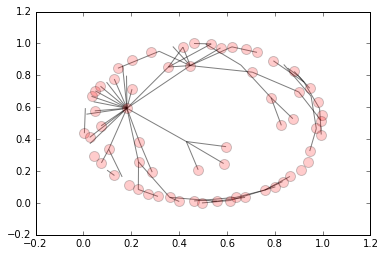

In [32]:
print 'Users that talk about topic0'

nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)

nx.draw_networkx_nodes(graph,pos,
                       nodelist=username_topic0,
                       node_color='r',
                       node_size=100,
                       alpha=0.2)

Users that talk about topic1


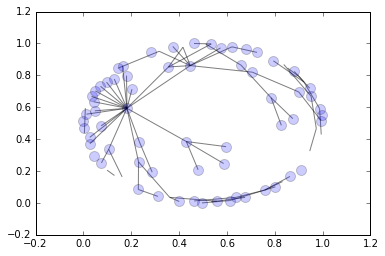

In [34]:
print 'Users that talk about topic1'

nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)

nx.draw_networkx_nodes(graph,pos,
                       nodelist=username_topic1,
                       node_color='b',
                       node_size=100,
                       alpha=0.2)

Users that talk about topic2


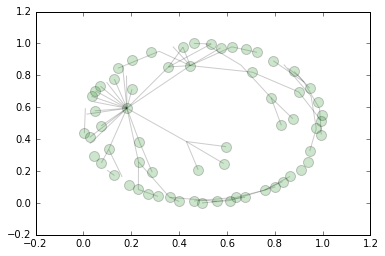

In [35]:
print 'Users that talk about topic2'

nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.2)

nx.draw_networkx_nodes(graph,pos,
                       nodelist=username_topic0,
                       node_color='g',
                       node_size=100,
                       alpha=0.2)

Users that talk about topic3


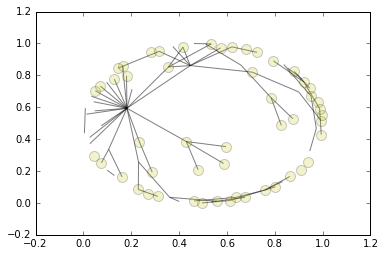

In [36]:
print 'Users that talk about topic3'

nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)

nx.draw_networkx_nodes(graph,pos,
                       nodelist=username_topic3,
                       node_color='y',
                       node_size=100,
                       alpha=0.2)

Color users by topic


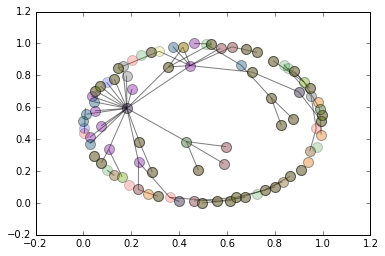

In [31]:
# graph = nx.cubical_graph()
pos=nx.spring_layout(graph) # positions for all nodes

# nodes
print 'Color users by topic'

nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)

nx.draw_networkx_nodes(graph,pos,
                       nodelist=username_topic0,
                       node_color='r',
                       node_size=100,
                       alpha=0.2)

nx.draw_networkx_nodes(graph,pos,
                       nodelist=username_topic1,
                       node_color='b',
                       node_size=100,
                       alpha=0.2)

nx.draw_networkx_nodes(graph,pos,
                       nodelist=username_topic2,
                       node_color='g',
                       node_size=100,
                       alpha=0.2)

nx.draw_networkx_nodes(graph,pos,
                       nodelist=username_topic3,
                       node_color='y',
                       node_size=100,
                       alpha=0.2)

#### Observations
At large, it seems like almost all users talk about each topic.

- Which users are unique and talk only about one topic?
- Which users talk about all topics?
- Which users only talk about specific topics?

In [83]:
# show users that talk only about one topic
unique_users_topic0 = list(set(username_topic0).difference(username_topic1).difference(username_topic2).difference(username_topic3))
unique_users_topic1 = list(set(username_topic1).difference(username_topic0).difference(username_topic2).difference(username_topic3))
unique_users_topic2 = list(set(username_topic2).difference(username_topic0).difference(username_topic1).difference(username_topic3))
unique_users_topic3 = list(set(username_topic3).difference(username_topic0).difference(username_topic1).difference(username_topic2))

print 'users that only talk about topic0: '
print unique_users_topic0
print 'users that only talk about topic1: ', unique_users_topic1
print 'users that only talk about topic2: '
print unique_users_topic2
print 'users that only talk about topic3: ', unique_users_topic3

users that only talk about topic0: 
['mustafaklash56', 'AbdusMujahid149', 'abutariq041', 'Afriqqiya_252', 'DawlaWitness11']
users that only talk about topic1:  ['04_8_1437', 'wayyf44rer']
users that only talk about topic2: 
['dieinurage29__7', 'Dieinurage308', 'freelance_112', 'abuayisha102', 'fahadslay614', 'al_nusra', '06230550_IS']
users that only talk about topic3:  ['saifulakhir']


In [84]:
# show users that talk about all topics
users_alltopic = list(set(username_topic0).intersection(username_topic1).intersection(username_topic2).intersection(username_topic3))
print users_alltopic

['grezz10', 'murasil1', 'Uncle_SamCoco', 'maisaraghereeb', 'Witness_alHaqq', 'ismailmahsud', 'Bajwa47online', 'MaghrabiArabi', 'NaseemAhmed50', 'Abu_Azzzam25', 'wayf44rerr', 'Freedom_speech2', 'abuhumayra4', 'ro34th', 'EPlC24', 'lNSlDEWAR', 'moustiklash', 'IbnKashmir_', '__alfresco__', 'FidaeeFulaani', 'Fidaee_Fulaani', 'WarReporter1', 'AsimAbuMerjem', 'thefIamesofhaqq', 'war_analysis', 'mobi_ayubi', 'warrnews', 'melvynlion', 'darulhijrateyni', 'Mountainjjoool', 'AbuMusab_110', '1515Ummah', 'st3erer']


Users that talk about all topics


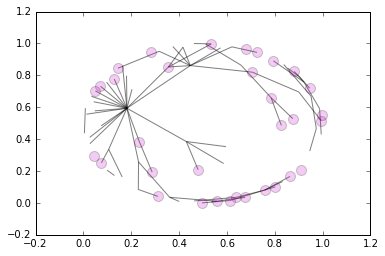

In [108]:
print 'Users that talk about all topics'

nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)

nx.draw_networkx_nodes(graph,pos,
                       nodelist=users_alltopic,
                       node_color='m',
                       node_size=100,
                       alpha=0.2)

In [102]:
# show distribution of topics per user
# create stacked bar graphs per user for all topics

# transform dataframe to columns for each topic
df_username_topic_T = df_username_topic.groupby(['username', 'topic']).size().unstack()

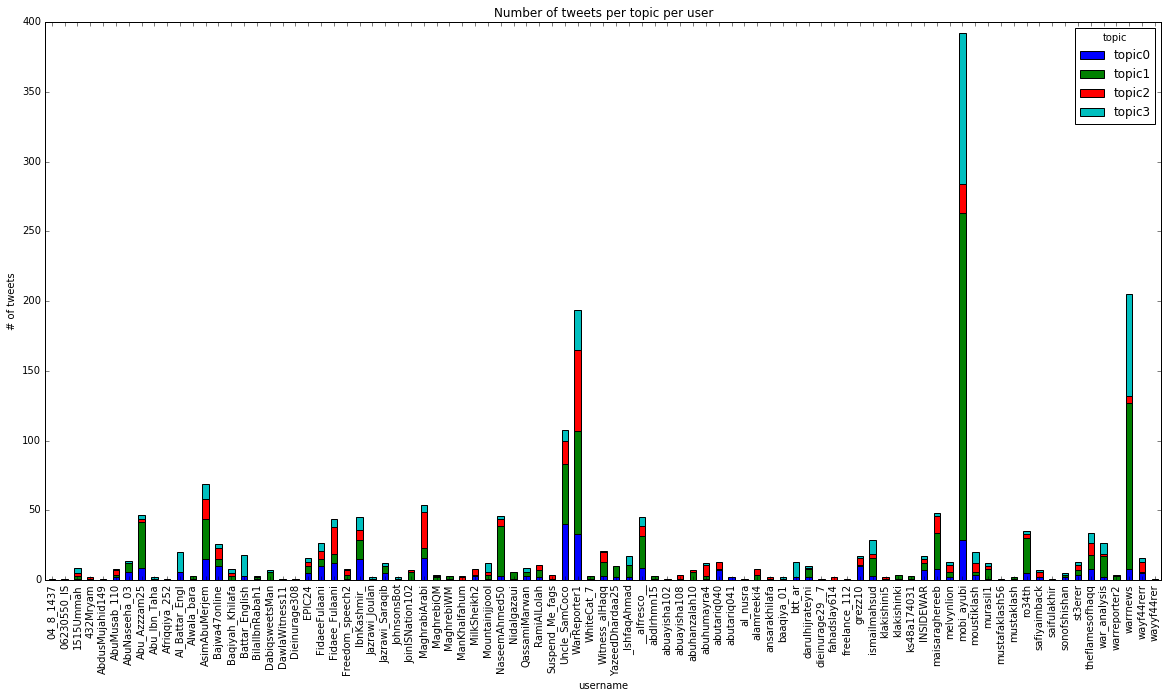

In [107]:
ax = df_username_topic_T.plot.bar(stacked=True, figsize=(20,10))
ax.set_ylabel("# of tweets")
ax.set_title('Number of tweets per topic per user')

#### Analyse edges per topic

Connections for topic0


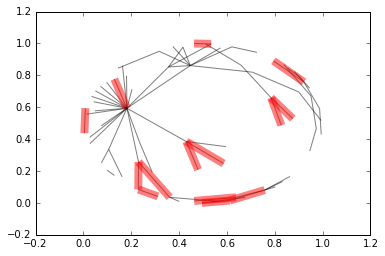

In [112]:
print 'Connections for topic0'

nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(graph,pos,
                       edgelist=connections_topic0,
                       width=8,alpha=0.5,edge_color='r')

Connections for topic1


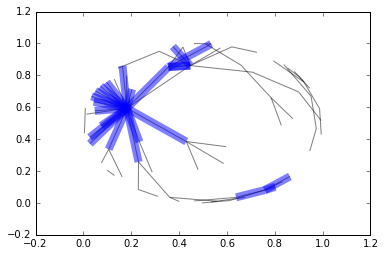

In [114]:
print 'Connections for topic1'

nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(graph,pos,
                       edgelist=connections_topic1,
                       width=8,alpha=0.5,edge_color='b')

Connections for topic2


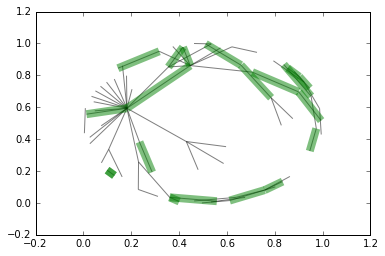

In [115]:
print 'Connections for topic2'

nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(graph,pos,
                       edgelist=connections_topic2,
                       width=8,alpha=0.5,edge_color='g')

Connections for topic3


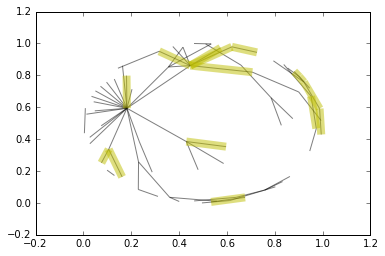

In [116]:
print 'Connections for topic3'

nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(graph,pos,
                       edgelist=connections_topic3,
                       width=8,alpha=0.5,edge_color='y')

Color connections by topic


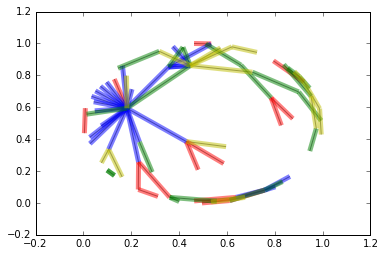

In [120]:
# color edges by topic

print 'Color connections by topic'
nx.draw_networkx_edges(graph,pos,width=1.0,alpha=0.5)

nx.draw_networkx_edges(graph,pos,
                       edgelist=connections_topic0,
                       width=5,alpha=0.5,edge_color='r')

nx.draw_networkx_edges(graph,pos,
                       edgelist=connections_topic1,
                       width=5,alpha=0.5,edge_color='b')

nx.draw_networkx_edges(graph,pos,
                       edgelist=connections_topic2,
                       width=5,alpha=0.5,edge_color='g')

nx.draw_networkx_edges(graph,pos,
                       edgelist=connections_topic3,
                       width=5,alpha=0.5,edge_color='y')


In [121]:
# show users that talk only about one topic
unique_connections_topic0 = list(set(connections_topic0).difference(connections_topic1).difference(connections_topic2).difference(connections_topic3))
unique_connections_topic1 = list(set(connections_topic1).difference(connections_topic0).difference(connections_topic2).difference(connections_topic3))
unique_connections_topic2 = list(set(connections_topic2).difference(connections_topic0).difference(connections_topic1).difference(connections_topic3))
unique_connections_topic3 = list(set(connections_topic3).difference(connections_topic0).difference(connections_topic2).difference(connections_topic2))

print 'connections that only talk about topic0: '
print unique_connections_topic0
print 'connections that only talk about topic1: '
print unique_connections_topic1
print 'connections that only talk about topic2: '
print unique_connections_topic2
print 'connections that only talk about topic3: '
print unique_connections_topic3

connections that only talk about topic0: 
[('Freedom_speech2', u'Jazrawi_Joulan'), ('Afriqqiya_252', u'Afriqqiya_252'), ('WhiteCat_7', u'mobi_ayubi'), ('DawlaWitness11', u'MaghrebiWM'), ('st3erer', u'AbuMusab_110'), ('sonofshishan', u'__alfresco__'), ('ro34th', u'Uncle_SamCoco'), ('AbuNaseeha_03', u'MaghrebiQM'), ('WarReporter1', u'Uncle_SamCoco'), ('abutariq041', u'emran_getu'), ('grezz10', u'RamiAlLolah'), ('darulhijrateyni', u'MaghrebiQM'), ('AbdusMujahid149', u'AbdusMujahid149'), ('wayf44rerr', u'AbuMusab_110'), ('Jazrawi_Saraqib', u'MaghrebiWM'), ('IbnKashmir_', u'Jazrawi_Saraqib'), ('mustafaklash56', u'mustafaklash56')]
connections that only talk about topic1: 
[('abdlrhmn15', u'RamiAlLolah'), ('JoinISNation102', u'Nidalgazaui'), ('warrnews', u'Nidalgazaui'), ('warreporter2', u'RamiAlLolah'), ('wayyf44rer', u'RamiAlLolah'), ('FidaeeFulaani', u'RamiAlLolah'), ('04_8_1437', u'04_8_1437'), ('Nidalgazaui', u'warrnews'), ('murasil1', u'WarReporter1'), ('abuhanzalah10', u'RamiAlLolah')

In [122]:
# show connections that talk about all topics
connections_alltopic = list(set(connections_topic0).intersection(connections_topic1).intersection(connections_topic2).intersection(connections_topic3))
print connections_alltopic

[]


Apperently there is no connection present that talks about each topic. 

In [ ]:
# show distribution of topics per user
# create stacked bar graphs per user for all topics

In [192]:
# # show edges and topics in a dataframe
# df_connections_topics = df_active[['username', 'tagged_profiles', 'topic']]
# print len(df_connections_topics)
# df_connections_topics.head()

1953


,username,tagged_profiles,topic
32,YazeedDhardaa25,[YazeedDhardaa25],topic0
174,YazeedDhardaa25,[RamiAlLolah],topic1
180,YazeedDhardaa25,[RamiAlLolah],topic0
181,YazeedDhardaa25,[RamiAlLolah],topic1
186,YazeedDhardaa25,[YazeedDhardaa25],topic1


In [225]:
# rename columns
df_connections_temp.columns = ['username', 'tagged_profiles']

print len(df_connections_temp)
df_connections_temp.head()

2004


,username,tagged_profiles
32,YazeedDhardaa25,YazeedDhardaa25
174,YazeedDhardaa25,RamiAlLolah
180,YazeedDhardaa25,RamiAlLolah
181,YazeedDhardaa25,RamiAlLolah
186,YazeedDhardaa25,YazeedDhardaa25


In [226]:
df_topic = df_active['topic']
df_topic = df_topic.to_frame('topic')

In [227]:
# merge dataframe including the topic with df_connections_temp
df_connections_temp = df_connections_temp.merge(df_topic, left_index=True, right_index=True)
print len(df_connections_temp)
df_connections_temp.head()

2004


,username,tagged_profiles,topic
32,YazeedDhardaa25,YazeedDhardaa25,topic0
174,YazeedDhardaa25,RamiAlLolah,topic1
180,YazeedDhardaa25,RamiAlLolah,topic0
181,YazeedDhardaa25,RamiAlLolah,topic1
186,YazeedDhardaa25,YazeedDhardaa25,topic1


In [228]:
# convert list of edges to dataframe column
df_connections_temp['connections'] = list(zip(df_connections_temp['username'], df_connections_temp['tagged_profiles']))

df_connections_temp = df_connections_temp[['connections', 'topic']]
print len(df_connections_temp)
df_connections_temp.head()

2004


,connections,topic
32,"(YazeedDhardaa25, YazeedDhardaa25)",topic0
174,"(YazeedDhardaa25, RamiAlLolah)",topic1
180,"(YazeedDhardaa25, RamiAlLolah)",topic0
181,"(YazeedDhardaa25, RamiAlLolah)",topic1
186,"(YazeedDhardaa25, YazeedDhardaa25)",topic1


In [246]:
# transform dataframe to columns for each topic
df_connections_temp_T = df_connections_temp.groupby(['connections', 'topic']).size().unstack()

In [247]:
# select for the plotting only the connections that occur more than five times
print len(df_connections_temp_T)
df_connections_temp_T = df_connections_temp_T[(df_connections_temp_T > 5).any(axis=1)]
len(df_connections_temp_T)

342


46

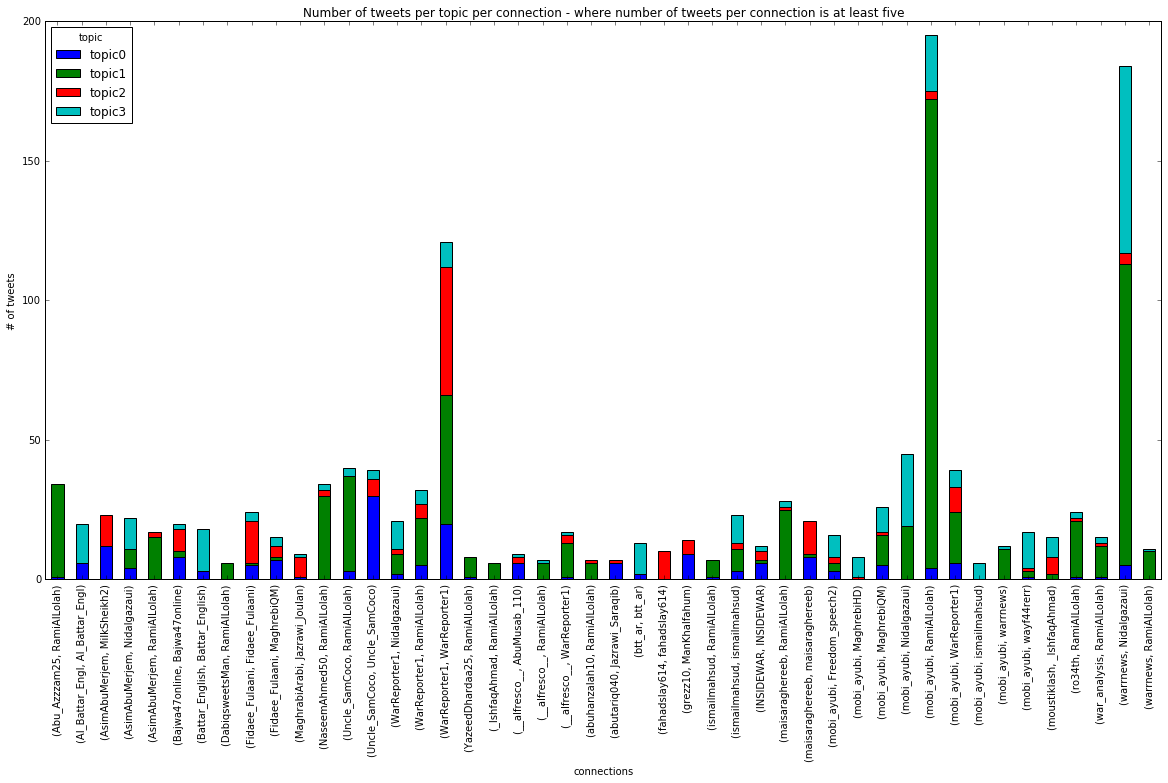

In [250]:
ax = df_connections_temp_T.plot.bar(stacked=True, figsize=(20,10))
ax.set_ylabel("# of tweets")
ax.set_title('Number of tweets per topic per connection - where number of tweets per connection is at least five')

Based on the results from this graph we notice that some topics are more popular among certain connections than are other topics.

### What's next

Next we are interested to get an understanding of the users that are early adopters of a topic and users that spread a particular topic when people already started talking about the topic.

Ultimately, we want to apply this exploration especially for topics that are, yet, not well known within the network.
Which means that we may be looking for key features instead of topics or that we should expand the number of topics that we currently explore. 